# Stardard NN su database MNIST

Neural network sviluppata in TensorFlow versione 1.x, su database MNIST.

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
tf.__version__

'1.15.2'

In [ ]:
#Import per interoperabilità python 2-3
#from __future__ import division

In [ ]:
from tensorflow import keras as ks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
#Per data visualization
import seaborn as sns

import time

print("Done")

Done


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Definizione metodi

In [ ]:
class TimeHistory(ks.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

print("Done")

Done


In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

print("Done")

Done


#Import del dataset
Import del dataset, e stampa della sua struttura.

In [ ]:
#Import del database MNIST
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

#Struttura dati nel database
print("Numero elementi e dimensione immagini in train set: " + str(train_images.shape))
print("Numero elementi e dimensione immagini in test set: " + str(test_images.shape))
print("Numero elementi label in train set: " + str(len(train_labels)))
print("Numero elementi label in test set: " + str(len(test_labels)))
print("Tipo di struttura del train set: " + str(type(train_images)) + ", composto da " + str(type(train_images[0])))
print("Tipo di struttura del label set: " + str(type(train_labels)) + ", composto da " + str(type(train_labels[0])))
print("Le etichette sono interi; valore più piccolo: " + str(np.amin(train_labels)) + ", valore più grande: " + str(np.amax(train_labels)))

11493376/11490434 [==============================] - 0s 0us/step
Numero elementi e dimensione immagini in train set: (60000, 28, 28)
Numero elementi e dimensione immagini in test set: (10000, 28, 28)
Numero elementi label in train set: 60000
Numero elementi label in test set: 10000
Tipo di struttura del train set: <class 'numpy.ndarray'>, composto da <class 'numpy.ndarray'>
Tipo di struttura del label set: <class 'numpy.ndarray'>, composto da <class 'numpy.uint8'>
Le etichette sono interi; valore più piccolo: 0, valore più grande: 9


##Struttura del database

Il database è diviso in training set e testing set.

Nel training set ci sono 60k immagini 28x28, e 60k etichette.

Nel test set ci sono 10k immagini 28x28 e 10k etichette.

L'immagine è formata da valori che variano da 0 a 255, e le etichette sono un intero tra 0 e 9.


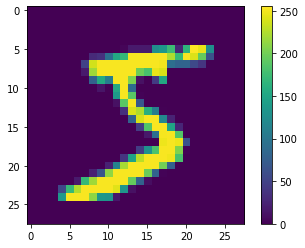

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [ ]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

#L'etichetta è un intero tra 0 e 9
train_labels

##Preprocessing dei dati
Scalo tutte le immagini nel range tra 0 e 1.

In [ ]:
#Preprocessing dei dati
#Scalo i valori nel range tra 0 e 1
train_images = train_images / 255.0

test_images = test_images / 255.0

print("Done")

Done


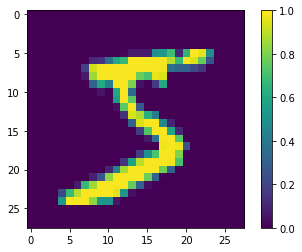

In [ ]:
#Controllo lo scaling dei dati
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Guardo un piccolo insieme di immagini con etichette corrispondenti assegnate.

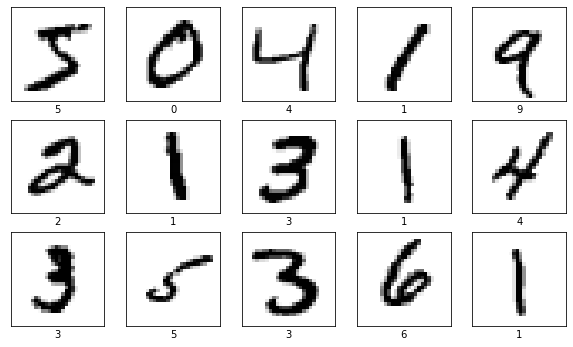

In [ ]:
plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

#Costruzione modello
Vado a costruire il modello.

Il primo layer del network, *tf.keras.layers.Flatten*, trasforma il formato delle immagini da un array bidimensionale ad un array monodimensionale (28x28 px -> 28*28=784 px).

Questo *layer* non ha parametri da imparare, è solo una manipolazione dei dati.

Dopo il *flattening* dei pixel, la network consiste di una sequenza di due layer *tf.keras.layers.Dense*. Questi sono neural layers "densamente" connessi, o pienamente connessi. Il primo layer *Dense* ha 256 nodi; il secondo layer ha 128 nodi, e l'ultimo layer è un 10-node *softmax* layer che ritorna un array di 10 *probability scores* che sommano a 1. Ogni nodo contiene un punteggio che indica con che probabilità l'immagine corrente appartiene ad una delle 10 classi.

**Compilare il modello**

Sono necessari alcuni settings prima di completare il modello. Questi sono aggiunti durante la fase *compile*:
* *Loss function* — Misura quanto accurato è il modello durante il training. Si vuole minimizzare la funzione affinchè "viri" nella direzione giusta.
* *Optimizer* — è il modo in cui il modello è aggiornato basandosi sui dati che vede e la loss function.
* *Metrics* — Usata per monitorare la fase di training e di testing. Il seguente esempio usa l'*accuracy*, la frazione delle immagini che sono correttamente classificate.

##Build

In [ ]:
keras_model = ks.models.Sequential()
keras_model.add(ks.layers.Flatten(input_shape=(28, 28)))

hidden1 = ks.layers.Dense(256, activation = 'relu')

hidden2 = ks.layers.Dense(128, activation = 'relu')

hidden3 = ks.layers.Dense(10, activation = 'softmax')

keras_model.add(hidden1)
keras_model.add(hidden2)
keras_model.add(hidden3)

print("Done")

Done


##Compile

In [ ]:
keras_model.compile(optimizer = 'adam', 
                    loss = 'sparse_categorical_crossentropy', 
                    metrics = ['accuracy'])

print(keras_model.summary())

print("Done")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
None
Done


##Traning del modello

Training diviso in step:
1. Passare ("feeding") il training data al modello. Nell'esempio, il training data sono  gli array `train_images` e `train_labels`.
2. Il modello impara ad associare immagini e labels.
3. Si chiede al modello di fare predizioni su un test set; in questo esempio, l'array `test_images`. Verifica che le previsioni corrispondano alle labels dall'array `test_labels`.

Per iniziare il training, chiamiamo il metodo `model.fit`; chiamato così perchè "fits" il modello al training data.

Passando in `model.fit` anche `validation_data`, il modello calcolerà la funzione di *accuray* e di *loss* anche rispetto ai dati di valutazione, ossia il test set.

In [ ]:
time_callback = TimeHistory()

history = keras_model.fit(train_images, train_labels, validation_data=(test_images, test_labels),
                          epochs=10, callbacks=[time_callback])

print("Done")

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 108us/sample - loss: 0.2061 - acc: 0.9388 - val_loss: 0.1221 - val_acc: 0.9623
Epoch 2/10
60000/60000 [==============================] - 6s 104us/sample - loss: 0.0869 - acc: 0.9733 - val_loss: 0.0879 - val_acc: 0.9713
Epoch 3/10
60000/60000 [==============================] - 6s 105us/sample - loss: 0.0585 - acc: 0.9819 - val_loss: 0.0903 - val_acc: 0.9720
Epoch 4/10
60000/60000 [==============================] - 6s 103us/sample - loss: 0.0448 - acc: 0.9851 - val_loss: 0.0739 - val_acc: 0.9789
Epoch 5/10
60000/60000 [==============================] - 6s 107us/sample - loss: 0.0328 - acc: 0.9897 - val_loss: 0.0809 - val_acc: 0.9777
Epoch 6/10
60000/60000 [==============================] - 6s 106us/sample - loss: 0.0277 - acc: 0.9904 - val_loss: 0.0885 - val_acc: 0.9771
Epoch 7/10
60000/60000 [==============================] - 6s 108us/sample - loss: 0.0255 - acc: 0.9919 - val_l

##Accuratezza

Dopo aver allenato il modello, ho una prima misura di accuratezza.

Questa non è un indicatore valido per indicare quanto la rete neurale abbia imparato, in quanto le predizioni di classificazione sono fatte su un set finito con labels già assegnate. Questo effetto è detto **overfitting**.

Utilizzo una porzione di dati non utilizzata nel training per misurare la precisione reale.

In [ ]:
#Misuro accuratezza
test_accuracy = keras_model.evaluate(test_images, test_labels)

print("Accuratezza: " + str(test_accuracy))

print("Time per epoch: " + str(time_callback.times))
total_time = time_callback.times
total_time_str = sum(total_time)
print("Total time: " + str(total_time_str))

print("Done")

10000/10000 [==============================] - 0s 45us/sample - loss: 0.0875 - acc: 0.9811
Accuratezza: [0.08749440627767917, 0.9811]
Time per epoch: [6.482546091079712, 6.245325803756714, 6.312908172607422, 6.200695037841797, 6.4053661823272705, 6.385027647018433, 6.490051031112671, 6.607197284698486, 6.329246520996094, 6.502779006958008]
Total time: 63.961142778396606
Done


In [ ]:
#history_dict = history.history
#print(history_dict.keys())

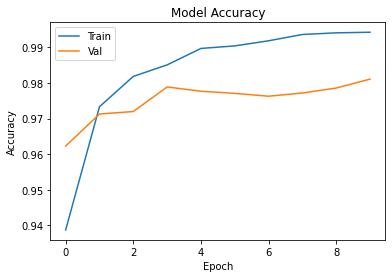

Time per epoch: [6.482546091079712, 6.245325803756714, 6.312908172607422, 6.200695037841797, 6.4053661823272705, 6.385027647018433, 6.490051031112671, 6.607197284698486, 6.329246520996094, 6.502779006958008]
Total time: 63.961142778396606


In [ ]:
#Visualize the models accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

print("Time per epoch: " + str(time_callback.times))
total_time = time_callback.times
total_time_str = sum(total_time)
print("Total time: " + str(total_time_str))

Difatti, la percentuale di accuratezza mostrata nel training è del 99,51%, che diventa del 97,99% se misurata sul test set.

##Matrice di confusione

Genero la matrice di confusione sul test set.

In [ ]:
#Necessito di un array con tutte le labels
classes=[0,1,2,3,4,5,6,7,8,9]

test_predictions = keras_model.predict_classes(test_images)

conf_matr = confusion_matrix(y_true = test_labels, y_pred = test_predictions)
print(conf_matr)

con_mat_norm = np.around(conf_matr.astype('float') / conf_matr.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                          index = classes, 
                          columns = classes)

[[ 973    0    1    0    1    1    1    1    2    0]
 [   0 1126    0    0    0    0    2    1    6    0]
 [   5    1 1010    3    0    0    2    4    6    1]
 [   0    0    2  993    0    4    0    4    4    3]
 [   3    0    3    0  951    0    5    0    0   20]
 [   4    0    0   10    1  869    2    1    3    2]
 [   4    2    0    0    2    7  939    0    4    0]
 [   3    1    7    2    1    0    0 1005    4    5]
 [   1    1    2    7    2    2    0    2  956    1]
 [   2    2    0    4    5    3    0    1    3  989]]


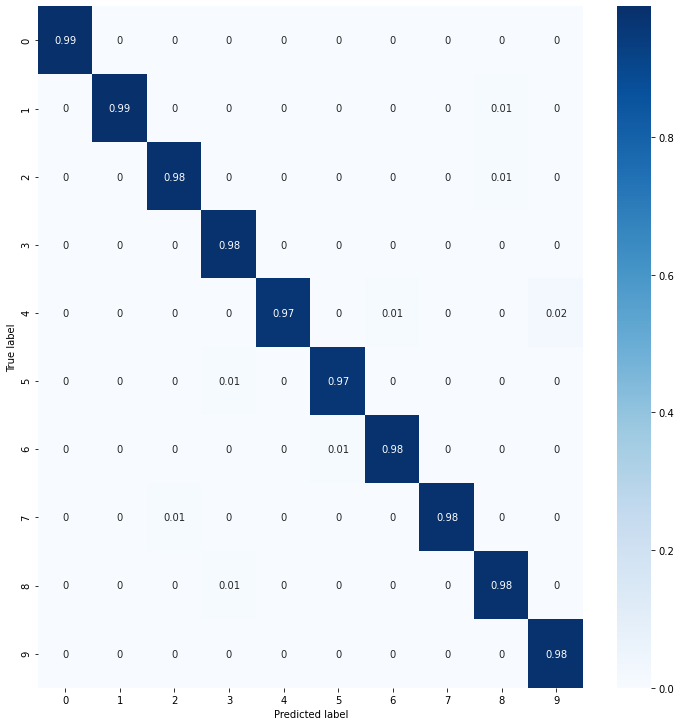

In [ ]:
figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#Test di predizione
Col modello addestrato, possiamo usarlo per fare predizioni su alcune immagini.

Con `model.predict(test)` ottengo una previsione su ogni elemento in `test`, per esempio 0.8 sulla classe 0 e 0.2 sulla classe 1.

Con `model.predict_classes(test)` ottengo la classe più probabile per ogni elemento, l'output è del tipo 0 o 1.

In [ ]:
predictions = keras_model.predict(test_images)

print("Done")

Done


Qui il modello ha predetto la label per ogni immagine nel testing set.

Guardo la prima predizione:

In [ ]:
predictions[0]

array([1.59520314e-11, 4.12329406e-08, 9.05767461e-09, 1.07210305e-07,
       6.97523568e-14, 2.18688023e-12, 3.90731913e-20, 9.99999881e-01,
       4.24948965e-10, 6.76634582e-10], dtype=float32)

La predizione è un array di 10 numeri. Rappresentano la "*confidence*" del modello sulla corrispondenza dell'immagine con ognuno dei 10 differenti label; per vedere la label con cui ha più "*confidence*":

In [ ]:
np.argmax(predictions[0])

7

Guardo l'etichetta e vedo se è corretto.

In [ ]:
test_labels[0]

7

Costruisco un grafico per guardare meglio alla predizione di più immagini.

Guardo l'immagine 0, la predizione e all'array di predizione.

Previsioni corrette delle labels sono blu e le incorrette sono rosse.

Il numero fornisce la percentuale per la label predetta.

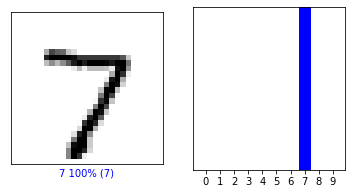

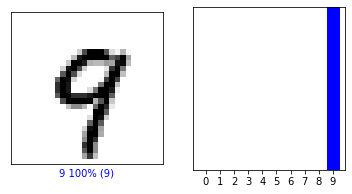

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Faccio il plot di diverse immagini con le loro predizioni. Il modello può essere sbagliato anche quando molto "confidente".

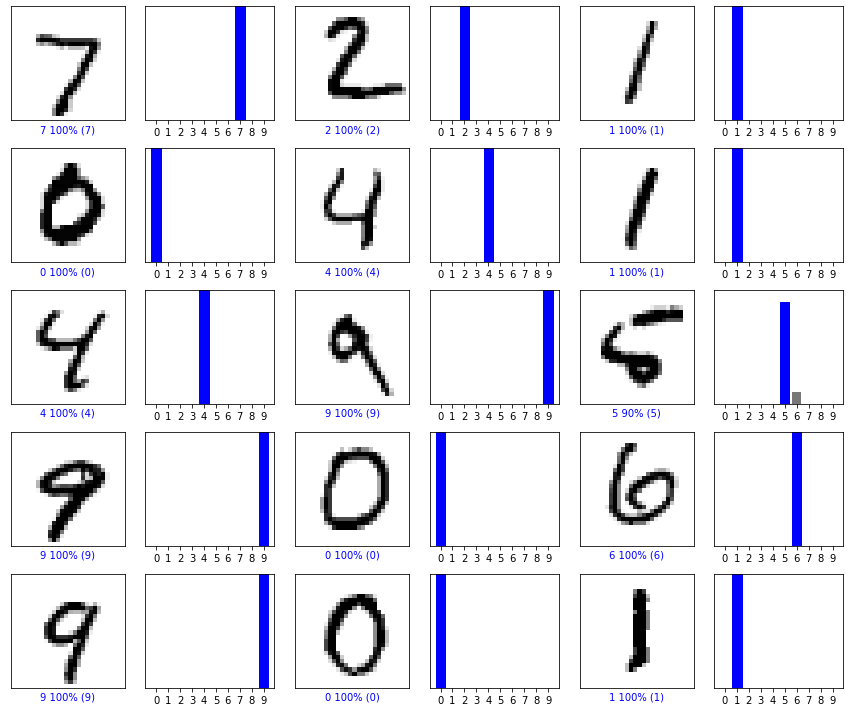

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Posso poi usare il modello addestrato per fare una predizione su una singola immagine.

In [ ]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


Modelli `tf.keras` sono ottimizzati per fare predizioni su *batch*, o collezioni, di esempi alla volta. Pertanto anche se la predizione è su 1 immagine, bisogna aggiungerla ad una lista.

In [ ]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


Ora predico la corretta label per questa immagine:

[[4.6483771e-15 1.3244497e-10 1.0000000e+00 3.1013427e-13 8.6523960e-24
  1.6742026e-19 1.5560856e-22 7.6431671e-18 3.9489561e-15 5.3775436e-23]]


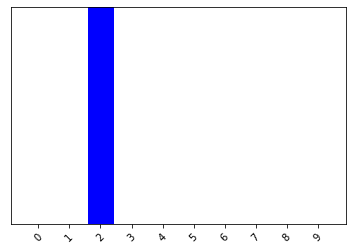

In [ ]:
predictions_single = keras_model.predict(img)

print(predictions_single)

class_names = [0,1,2,3,4,5,6,7,8,9]
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`model.predict` ritorna una lista di liste - una lista per ogni immagine nel batch di dati.

Prendo le predizioni per il nostro batch (di 1 elemento) di dati:

In [ ]:
np.argmax(predictions_single[0])

2

Che dovrebbe predirre la label come atteso.

#Analisi errori

In [ ]:
incorrects = np.nonzero(keras_model.predict_classes(test_images) != test_labels)

temp_incorrects = list()
for elem in incorrects[0]:
  #print(elem)
  temp_incorrects.append(elem)
incorrects = temp_incorrects

In [ ]:
len(incorrects)

189

In [ ]:
wrong_labels_str = list()
#wrong_labels = list()
for elem in incorrects:
  '''
  Ogni elemento in incorrects, ossia ogni elem, è un numero.
  Tale numero indica quegli indici FALLITI all'interno del test set (test_labels_encoded).
  E' quindi un array di numeri, 3, 7, 9 ecc, ed ogni numero indica il file che ha fallito la previsione.

  Se 3, indica che il file 3 in test_labels_encoded ha FALLITO la previsione.
  Prelevo quel file da test_labels_encoded; se 3, test_labels_encoded[3] ritorna un intero,
  ossia l'encode della label corrispondente.
  '''
  string_to_append = str(test_labels[elem])
  wrong_labels_str.append(string_to_append)

In [ ]:
len(wrong_labels_str)

189

In [ ]:
from collections import Counter

count_labels_err = Counter(wrong_labels_str)

In [ ]:
count_labels_ordered = count_labels_err.most_common()
for elem in count_labels_ordered:
  print(elem)

('4', 31)
('7', 23)
('5', 23)
('2', 22)
('9', 20)
('6', 19)
('8', 18)
('3', 17)
('1', 9)
('0', 7)


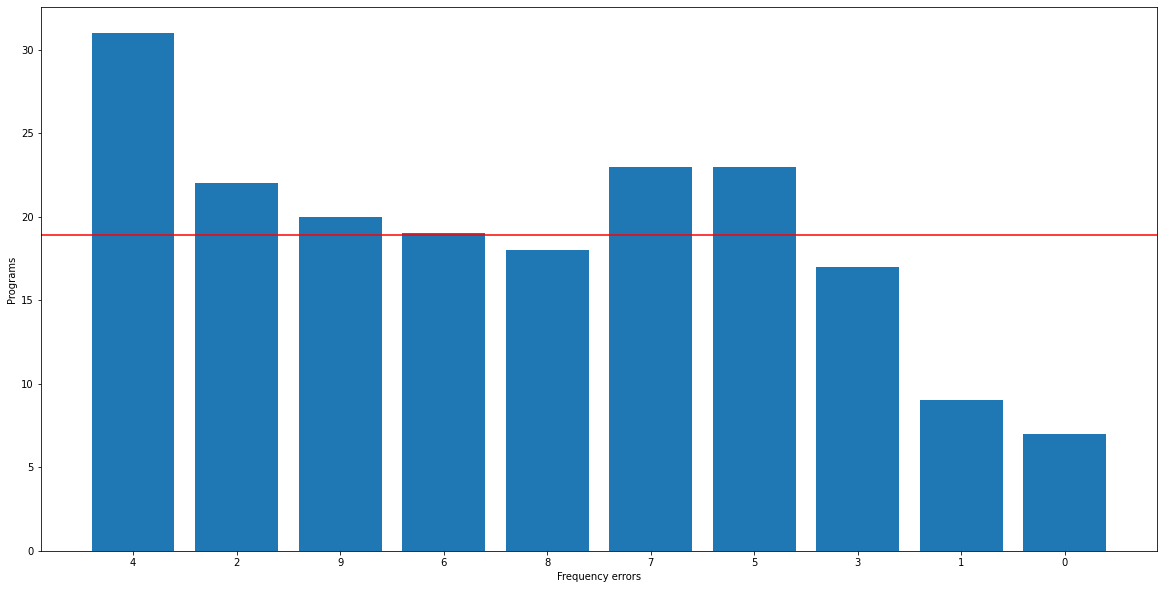

In [ ]:
plt.figure(figsize=(20, 10))
plt.axhline(np.asarray(list(count_labels_err.values())).mean(), color="red") # Horizontal line adding the threshold
plt.bar(list(count_labels_err.keys()), list(count_labels_err.values()))

plt.xlabel("Frequency errors") # x label
plt.ylabel("Programs") # y label
plt.show()

#Test visualizzazione activation x layer

In [ ]:
pip install keract

In [ ]:
'''
from keract import get_activations, display_activations
keract_inputs = test_images[:1]
keract_targets = test_labels[:1]
activations = get_activations(keras_model, keract_inputs)
display_activations(activations, cmap="gray", save=False)

'''

'\nfrom keract import get_activations, display_activations\nkeract_inputs = test_images[:1]\nkeract_targets = test_labels[:1]\nactivations = get_activations(keras_model, keract_inputs)\ndisplay_activations(activations, cmap="gray", save=False)\n\n'

In [ ]:
'''
from keract import get_activations, display_heatmaps
keract_inputs = test_images[:1]
keract_targets = test_labels[:1]
activations = get_activations(keras_model, keract_inputs)
display_heatmaps(activations, keract_inputs, save=False)
'''

'\nfrom keract import get_activations, display_heatmaps\nkeract_inputs = test_images[:1]\nkeract_targets = test_labels[:1]\nactivations = get_activations(keras_model, keract_inputs)\ndisplay_heatmaps(activations, keract_inputs, save=False)\n'

In [ ]:
import keract
from keract import get_activations
activations = get_activations(keras_model, [test_images, test_labels], auto_compile=True)

In [ ]:
[print(k, '->', v.shape, '- Numpy array') for (k, v) in activations.items()]

flatten_1_input -> (10000, 28, 28) - Numpy array
flatten_1 -> (10000, 784) - Numpy array
dense_3 -> (10000, 256) - Numpy array
dense_4 -> (10000, 128) - Numpy array
dense_5 -> (10000, 10) - Numpy array


[None, None, None, None, None]

In [ ]:
keract.display_activations(activations, cmap=None, save=False, directory='.', data_format='channels_last')

flatten_1_input (10000, 28, 28) -> Skipped. First dimension is not 1.
flatten_1 (10000, 784) -> Skipped. First dimension is not 1.
dense_3 (10000, 256) -> Skipped. First dimension is not 1.
dense_4 (10000, 128) -> Skipped. First dimension is not 1.
dense_5 (10000, 10) -> Skipped. First dimension is not 1.


In [ ]:
keract.display_heatmaps(activations, test_images[0], save=False)

flatten_1_input (10000, 28, 28) -> Skipped. First dimension is not 1.
flatten_1 (10000, 784) -> Skipped. First dimension is not 1.
dense_3 (10000, 256) -> Skipped. First dimension is not 1.
dense_4 (10000, 128) -> Skipped. First dimension is not 1.
dense_5 (10000, 10) -> Skipped. First dimension is not 1.
